  # Project: Loan Default Predictor

In [122]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [123]:
df = pd.read_csv(r'E:\My_Portfolio_Projects\ML Models\Loan_prediction_model\lending_club_loan_two.csv', encoding='utf-8') 
color1 = 'red'
color2 = '#4B0082'

 # Data Preprocessing

In [124]:
df.head(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [126]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


### Remove Unnecessary Columns

In [127]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [128]:

df.drop(['emp_title' , 'initial_list_status' , 'application_type' , 'mort_acc' , 'address','issue_d','purpose','title' ,'pub_rec' ], axis=1 , inplace = True )


### Fix data types  

In [129]:
df.dtypes

loan_amnt               float64
term                     object
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
dti                     float64
earliest_cr_line         object
open_acc                float64
revol_bal               float64
revol_util              float64
total_acc               float64
pub_rec_bankruptcies    float64
dtype: object

In [130]:

categorical_cols = ['term', 'grade', 'sub_grade', 'verification_status', 'home_ownership', 
                    'loan_status']
for col in categorical_cols : 
   df[col] =  df[col].astype('category')

In [131]:
df['loan_amnt'] = df['loan_amnt'].replace({r'\$' : '' , ',' : ''} , regex = True).astype(float)

In [132]:
df.dtypes

loan_amnt                float64
term                    category
int_rate                 float64
installment              float64
grade                   category
sub_grade               category
emp_length                object
home_ownership          category
annual_inc               float64
verification_status     category
loan_status             category
dti                      float64
earliest_cr_line          object
open_acc                 float64
revol_bal                float64
revol_util               float64
total_acc                float64
pub_rec_bankruptcies     float64
dtype: object

### Understand Missing Data

In [133]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
dti                         0
earliest_cr_line            0
open_acc                    0
revol_bal                   0
revol_util                276
total_acc                   0
pub_rec_bankruptcies      535
dtype: int64

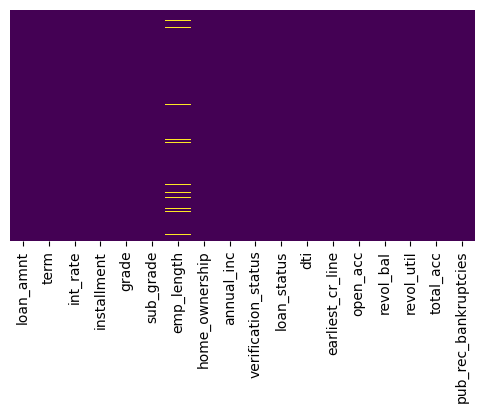

In [134]:
# checking missing value with heatmap .
plt.figure(figsize=(6,3))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False , color = '#4B0082')
plt.show()

### Imputation For Misssing Data

In [135]:
#   revol_util
# I am gonna Use median because percentage values are numeric and the median is robust to outliers.
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())  

In [136]:
# Fill missing values in 'emp_length' with the most frequent value
df['emp_length'] = df['emp_length'].fillna(df['emp_length'].mode()[0])

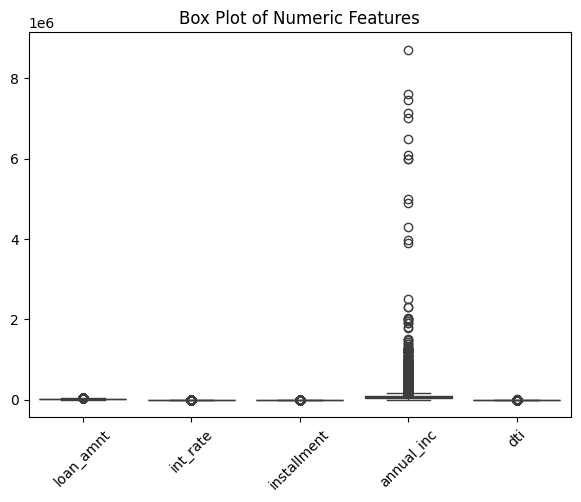

In [137]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df[['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti']] , color='#4B0082')
plt.xticks(rotation=45)
plt.title("Box Plot of Numeric Features")
plt.show()

###   Outliers removal

In [138]:
# we will use IQR for the following columns 'pub_rec', 'dti', 'open_acc' , 'revol_util' Cause its outliers doesn't make sence or they may errors 
df_original = df.copy()

def remove_outliers(df, columns):
    for col in columns:
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        before_count = df.shape[0] 
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        after_count = df.shape[0] 

        print(f"Removed {before_count - after_count} outliers from '{col}'")

    return df 

outlier_con_columns = ['dti', 'open_acc' , 'revol_util']
df = remove_outliers(df, outlier_con_columns)

Removed 275 outliers from 'dti'
Removed 10280 outliers from 'open_acc'
Removed 12 outliers from 'revol_util'


In [139]:
# we will use 'winsorization' method for those outliers that are not necesserly errors but it's a valueble information.
def winsorization(series , lower_percentile=1 , upper_percentile=99): 
    lower_bond = np.percentile(series , lower_percentile)
    upper_bond = np.percentile(series , upper_percentile)
    return np.clip(series , lower_bond , upper_bond) 

df['loan_amnt'] = winsorization(df['loan_amnt'])
df['int_rate'] = winsorization(df['int_rate'])
df['installment'] = winsorization(df['installment'])
df['total_acc'] = winsorization(df['total_acc'])
df['pub_rec_bankruptcies'] = winsorization(df['pub_rec_bankruptcies'])

In [140]:
# the two columns revol_bal and annual_income may not have outliers so we will use 'LOG TRANSFORMATION' for skewed data 
df['annual_inc'] = np.log1p(df['annual_inc'])
df['revol_bal'] = np.log1p(df['revol_bal'])

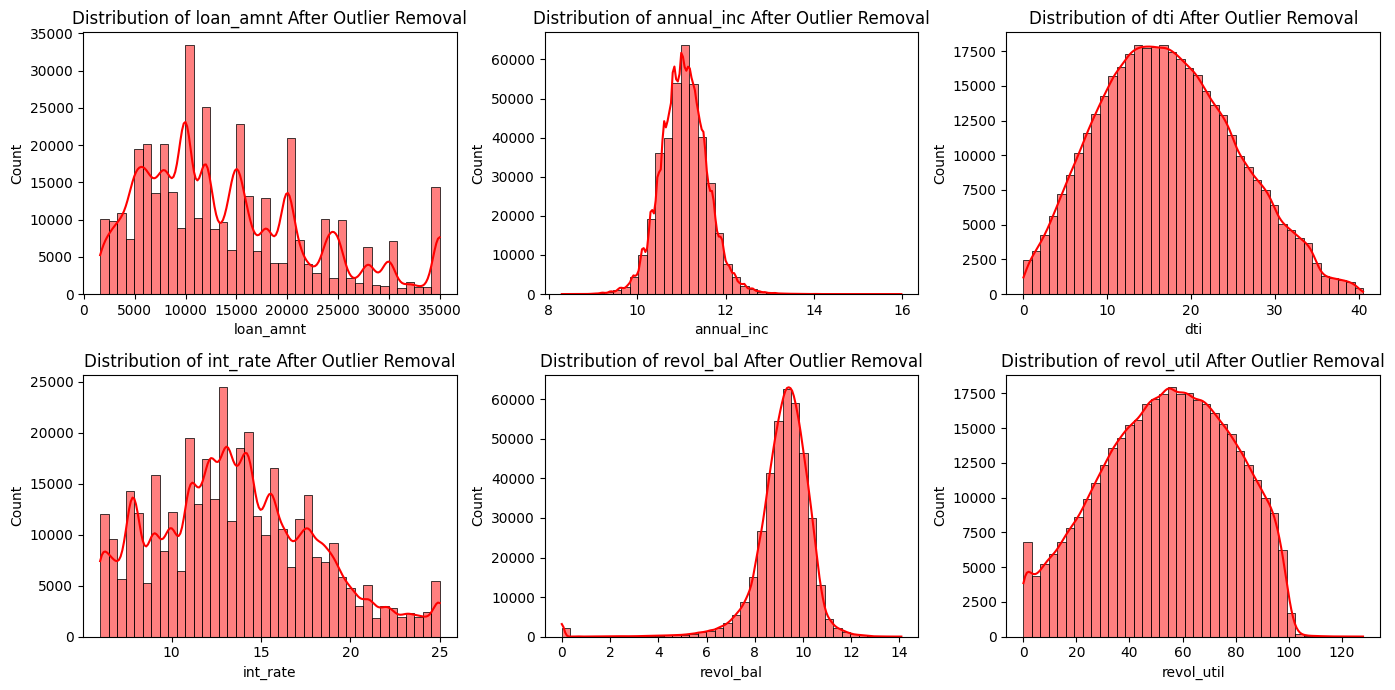

In [141]:
# Visualize selected numerical columns after cleaning
fig, axes = plt.subplots(2, 3, figsize=(14, 7) )
selected_cols = ['loan_amnt', 'annual_inc', 'dti', 'int_rate', 'revol_bal', 'revol_util']

for i, col in enumerate(selected_cols):
    sns.histplot(df[col], bins=40, kde=True, ax=axes[i//3, i%3] , color='red' )
    axes[i//3, i%3].set_title(f'Distribution of {col} After Outlier Removal')

plt.tight_layout()
plt.show()

###     Feature Engineering

In [142]:
df_cleaned = df.copy()

In [143]:
df_cleaned.head(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,dti,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc,pub_rec_bankruptcies
0,10000.0,36 months,11.44,329.48,B,B4,10+ years,RENT,11.669938,Not Verified,Fully Paid,26.24,Jun-1990,16.0,10.501500,41.8,25.0,0.0
1,8000.0,36 months,11.99,265.68,B,B5,4 years,MORTGAGE,11.082158,Not Verified,Fully Paid,22.05,Jul-2004,17.0,9.910066,53.3,27.0,0.0
2,15600.0,36 months,10.49,506.97,B,B3,< 1 year,RENT,10.670303,Source Verified,Fully Paid,12.79,Aug-2007,13.0,9.391661,92.2,26.0,0.0


In [144]:
# new column loan to income ratio
df['loan_to_income_ratio'] = df['loan_amnt'] / df['annual_inc']

In [145]:
# another column installment to income 
df['monthly_inc'] = df['annual_inc'] / 12
df['installment_to_income'] = df['monthly_inc'] / df['installment']

In [146]:
# credit age
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%Y' , errors='coerce')
df['credit_age'] = (pd.Timestamp.today() - df['earliest_cr_line']).dt.days / 365.25
df['credit_age'] = df['earliest_cr_line'].dt.strftime('%b-%Y')

In [147]:
# One-Hot Encoding With drop_first = True for homeOwnership 
df = pd.get_dummies(df, columns=['home_ownership'], drop_first=True)

for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

In [148]:
# term in months 
df['term_in_months'] = df['term'].str.extract('(\\d+)').astype(int)

In [149]:
# number for emp_length 
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
         '6 years', '7 years', '8 years', '9 years', '10+ years']

df['emp_length_encoded'] = pd.Categorical(df['emp_length'], categories=order, ordered=True).codes                                            

In [150]:
# numbers for each grade so model can understand 
grade_order = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df['grade_encoded'] = df['grade'].map(grade_order)

In [151]:
# Encoding sub_grade  (   A1 is best, G5 is worst   )
sub_grade_order = [f"{g}{n}" for g in "ABCDEFG" for n in range(1, 6)] 
df['sub_grade_encoded'] = pd.Categorical(df['sub_grade'], categories=sub_grade_order, ordered=True).codes

In [152]:
# decoding loan status for prediction 
df['loan_status_decode'] = df['loan_status']
df['loan_status_decode'] = df['loan_status_decode'].map({'Fully Paid' : 0 , 'Charged Off' : 1 })

In [153]:
df.head(2)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,verification_status,loan_status,...,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,term_in_months,emp_length_encoded,grade_encoded,sub_grade_encoded,loan_status_decode
0,10000.0,36 months,11.44,329.48,B,B4,10+ years,11.669938,Not Verified,Fully Paid,...,0,0,0,0,1,36,10,6,8,0
1,8000.0,36 months,11.99,265.68,B,B5,4 years,11.082158,Not Verified,Fully Paid,...,1,0,0,0,0,36,4,6,9,0


In [154]:
print(df['verification_status'].value_counts())

verification_status
Verified           135150
Source Verified    127951
Not Verified       122362
Name: count, dtype: int64


In [155]:
df = pd.get_dummies(df, columns=['verification_status'], drop_first=True)

#it showing 'bool' data types we have to convert it to 'integer' so model will understand it better 
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

In [156]:
df_transformed = df.copy()

###      Train-Test Split , Standard Scaling and Handling Imbalanced Data

In [174]:
# Drop raw categorical columns and target from the features
un_usfull = ['term', 'grade', 'sub_grade', 'emp_length', 'loan_status', 'earliest_cr_line', 'credit_age' ]
X = df.drop(columns = un_usfull + ['loan_status_decode', 'loan_to_income_ratio' , 'installment', 'pub_rec_bankruptcies'
                                    , 'monthly_inc'])# VIF of these columns are very high so i need to remove it  

# X = df.drop(columns = un_usfull + ['loan_status_decode', 'pub_rec_bankruptcies',
#                                    'installment'])# VIF of these columns are very high so i need to remove it  
 
y = df['loan_status_decode']

In [158]:

# # Split the data 80% training, 20% testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # rus = RandomUnderSampler(random_state=42)
# # X, y = rus.fit_resample(x, y)
# # print("Class Distribution After Undersampling:")
# # print(y.value_counts())

# scaler = StandardScaler()

# # Fit on training data and transform both training and test data
# x_train_scaled = scaler.fit_transform(X_train)
# x_test_scaled = scaler.transform(X_test)  

# x_train_scaled = pd.DataFrame(x_train_scaled, columns=X_train.columns)
# x_test_scaled = pd.DataFrame(x_test_scaled, columns=X_test.columns)


# # print("Scaled Training Features")
# # print(x_train_scaled)

In [159]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_cols = X_train.select_dtypes(include=['number']).columns
X_train_numeric = X_train[numeric_cols]
# SMOTE OverSampling 
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_numeric, y_train)
print("Class Distribution After SMOTE:")
print(y_train_res.value_counts())

print(X_train_res.isnull().sum()[X_train_res.isnull().sum() > 0])


# Random UnderSampling
# rus = RandomUnderSampler(random_state=42)
# X_train_rus , y_train_rus = rus.fit_resample(X_train, y_train)
# print("Class Distribution After SMOTE:")
# print(y_train_rus.value_counts)

print(X_train.isnull().sum())
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train_res)
x_test_scaled = scaler.transform(X_test)  

# After SMOTE
print("NaNs in X_train_res:", pd.DataFrame(X_train_res).isna().sum().sum())

# After scaling
print("NaNs in x_train_scaled:", np.isnan(x_train_scaled).sum())
print("NaNs in x_test_scaled:", np.isnan(x_test_scaled).sum())

# Check X_test before scaling
print("NaNs in X_test:", pd.DataFrame(X_test).isna().sum().sum())




Class Distribution After SMOTE:
loan_status_decode
1    248275
0    248275
Name: count, dtype: int64
Series([], dtype: int64)
loan_amnt                              0
int_rate                               0
annual_inc                             0
dti                                    0
open_acc                               0
revol_bal                              0
revol_util                             0
total_acc                              0
installment_to_income                  0
home_ownership_MORTGAGE                0
home_ownership_NONE                    0
home_ownership_OTHER                   0
home_ownership_OWN                     0
home_ownership_RENT                    0
term_in_months                         0
emp_length_encoded                     0
grade_encoded                          0
sub_grade_encoded                      0
verification_status_Source Verified    0
verification_status_Verified           0
dtype: int64


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- grade_encoded


In [168]:
from sklearn.metrics import accuracy_score, precision_score, recall_score , f1_score , roc_auc_score , confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC 
import lightgbm as lgb

models = {
    'LogisticRegression': LogisticRegression( random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
}

results= {}
for model_name , model in models.items():
    if model_name == 'LogisticRegression':
       model.fit(x_train_scaled, y_train_res)
       y_pred = model.predict(x_test_scaled)
    else:
         model.fit(X_train_res, y_train_res)
         y_pred = model.predict(X_test)
        
    roc_auc_score = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score = f1_score(y_test, y_pred)
    confusion_Matrics = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'roc_auc': roc_auc_score,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1_score,
        'confusion_matrix': confusion_Matrics
    }
for model_name, metrics in results.items():
    print(f'{model_name}')
    print(f'roc_auc: {metrics["roc_auc_score"]:.2f}')
    print(f'accuracy: {metrics["accuracy"]:.2f}')
    print(f'precision: {metrics["precision"]:.2f}')
    print(f'recall: {metrics["recall"]:.2f}')
    print(f'f1: {metrics["f1_score"]:.2f}')
    print(f'confusion_matrix:\n {metrics["confusion_matrix"]}')


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# def calculate_vif(df):
#     vif_data = pd.DataFrame()
#     vif_data['Feature_name'] = df.columns
    
#     # the below is a list comprehension 
#     vif_data['VIF Values'] = [variance_inflation_factor(df.values,col_index) for col_index in range(df.shape[1])] # the shape[] give us number of column in a dataset
#     return vif_data

In [ ]:
# X_train is our data with features that we want to check for redundancy.
# X_selected = X_train.copy()  
# vif_result = calculate_vif(X_selected)  
# print(vif_result) 

# Exploratory Data Analysis

In [ ]:
# Group data by 'grade' and 'loan_status' and count the occurrences
stacked_data = df_cleaned.groupby(['grade', 'loan_status'] , observed=True).size().unstack(fill_value=0)

# stacked bar plot
ax = stacked_data.plot(kind='bar', stacked=True , figsize=(6, 4) , color = [color2, color1])
plt.title("Loan Count by Grade")
plt.xlabel("Loan Grade")
plt.ylabel("Count of Loans")
plt.legend(title="Loan Status")
ax.set_facecolor(color='white')
plt.show()

In [ ]:
# List of crucial categorical columns
crucial_columns = ['grade','home_ownership','loan_status']

# Create subplots: one row with as many columns as we have crucial columns
fig, axes = plt.subplots(1, len(crucial_columns), figsize=(6 * len(crucial_columns), 6))

# for ax, col in zip(axes, crucial_columns):
#     # Count the occurrences in each category for the column and plot as a bar chart
#     df_cleaned[col].value_counts().plot(kind='bar', ax=ax, color=color2)
#     ax.set_title(f'Count of Loans by {col}', fontsize=14, fontweight='bold')
#     ax.set_xlabel(col, fontsize=12)
#     ax.set_ylabel("Count", fontsize=12)
#     ax.tick_params(axis='x', rotation=45)

                   # OR

for i, col in enumerate(crucial_columns):
    # Count the occurrences in each category for the column and plot as a bar chart
    df_cleaned[col].value_counts().plot(kind='bar', ax=axes[i], color=color2)
    axes[i].set_title(f'Count of Loans by {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("Count", fontsize=12)
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()



In [ ]:
plt.figure(figsize=(7,5))
sns.violinplot(x='grade', y='annual_inc', data=df_cleaned , linecolor = 'black' , color = color2)
plt.title("Annual Income Distribution by Loan Grade")
plt.xlabel("Loan Grade")
plt.ylabel("Annual Income")
plt.show()           

In [ ]:
df_transformed.columns

In [ ]:
selected_features = ['loan_amnt' ,'annual_inc', 'int_rate' , 'loan_to_income_ratio']
sns.pairplot(df_transformed[selected_features] )
plt.suptitle("Pairwise Relationships Among Loan Features", y=1.02)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
numeric_features = ['loan_amnt', 'annual_inc', 'int_rate', 'installment', 'loan_to_income_ratio']
corr_matrix = df[numeric_features].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### PCA (Principal Component Analysis)

In [ ]:
# from sklearn.decomposition import PCA
# # Plot explained variance ratio
# pca = PCA(n_components=12)

# # Fit PCA on your data and transform it to get the new, smaller features.
# x_pca = pca.fit_transform(x_train_scaled)
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
# plt.title('Cumulative Explained Variance')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid()
# plt.show()
# # This means the first 15 principal components together explain 95% or 97% of the total variance so we will keep only 15 or 12

In [ ]:
# Let's say you already have your features in X (only numeric ones)
# For our example, we want to reduce our features to 2 principal components.
# pca = PCA(n_components=0.95)
# # pca = PCA(n_components=0.95) or in my case i can use 0.95 becuase 14 pc's are equal to 95% variance in my dataset 

# # Fit PCA on your data and transform it to get the new, smaller features.
# x_pca = pca.fit_transform(x_train_scaled)

# explained_variance = pca.explained_variance_ratio_
# plt.figure(figsize=(8,5))
# sns.barplot(x=list(components), y=explained_variance, alpha=0.7, color=color2)
# plt.xlabel("Principal Components")
# plt.ylabel("Explained Variance")
# plt.title("Explained Variance by Principal Components")
# plt.show()

In [ ]:
# from sklearn.metrics import accuracy_score
# from sklearn.decomposition import PCA
# from sklearn.ensemble import RandomForestClassifier
# import time 

In [ ]:
# model = RandomForestClassifier(random_state=42)

# # Before PCA

# start_time = time.time()
# model.fit(X_train, y_train)
# end_time = time.time()
# training_time_before = end_time - start_time

# # Predictions
# y_pred_before = model.predict(X_test)

# # Accuracy Before PCA
# accuracy_before = accuracy_score(y_test, y_pred_before)

# print("Training Time Before PCA:", training_time_before)
# print("Accuracy Before PCA:", accuracy_before)

# # Apply PCA
# pca = PCA(n_components=12)  # i will Keep 12 components
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

# # After PCA
# start_time = time.time()
# model.fit(X_train_pca, y_train)
# end_time = time.time()
# training_time_after = end_time - start_time

# # Predictions
# y_pred_after = model.predict(X_test_pca)

# # Accuracy After PCA
# accuracy_after = accuracy_score(y_test, y_pred_after)

# print("Training Time (After PCA):", training_time_after)
# print("Accuracy (After PCA):", accuracy_after)

# # Compare Results
# print("\n--- Comparison ---")
# print(f"Training Time Reduced? {'Yes' if training_time_after < training_time_before else 'No'}")
# print(f"Accuracy Change: {accuracy_after - accuracy_before:.4f}")

# # the result is 
# # Training Time Before PCA: 223.3123242855072
# # Accuracy Before PCA: 0.80528835194894
# # Training Time After PCA: 229.27585411071777
# # Accuracy After PCA: 0.8037991034115949


# # that means it cauldn't improved accuracy and speed so we won't use it 


In [ ]:
X_train.head()

#### Checking class distribution 

In [ ]:
import matplotlib.pyplot as plt

# Check class distribution
class_counts = y_train.value_counts()

plt.figure(figsize=(6,4))
plt.bar(class_counts.index, class_counts.values, color=[color2, 'red'])
# sns.barplot(x=list(class_counts.index), y=class_counts.values, color=color2)
plt.xticks([0,1], labels=['Non-Defaulters (0)', 'Defaulters (1)'])
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before Handling Imbalance")
plt.show()

# Print class ratio
print(f"Non-Defaulters: {class_counts[0]} ({class_counts[0] / len(y_train):.2%})")
print(f"Defaulters: {class_counts[1]} ({class_counts[1] / len(y_train):.2%})")


# Model Training 

### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,precision_score,recall_score , roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(x_train_scaled, y_train)
xtrain_pred = model.predict(x_train_scaled)
xtest_pred = model.predict(x_test_scaled)
print(f"train accuracy:{accuracy_score(y_train, xtrain_pred):.2f}")
print(f"test accuracy: {accuracy_score(y_test,xtest_pred):.2f}")
print("Test Confusion Matrix:\n", confusion_matrix(y_test, xtest_pred))

In [ ]:
test_pred = model.predict(x_test_scaled)
test_proba = model.predict_proba(x_test_scaled)[:, 1]
print("Class 0 F1:", f1_score(y_test, test_pred, pos_label=0))
print("Class 1 F1:", f1_score(y_test, test_pred))
print("ROC-AUC:", roc_auc_score(y_test, test_proba))

### DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# model = DecisionTreeClassifier(random_state=42 , max_depth=3 , criterion='gini' , min_samples_leaf=10 , min_samples_split=10 , 
#                         )
# model.fit(x_train_scaled, y_train)

# model.fit(x_train_scaled, y_train)
# xtrain_pred = model.predict(x_train_scaled)
# xtest_pred = model.predict(x_test_scaled)
# print(f"train accuracy:{accuracy_score(y_train, xtrain_pred):.2f}")
# print(f"test accuracy: {accuracy_score(y_test,xtest_pred):.2f}")
# print("Test Confusion Matrix:\n", confusion_matrix(y_test, xtest_pred))

In [ ]:
# test_pred = model.predict(x_test_scaled)
# test_proba = model.predict_proba(x_test_scaled)[:, 1]
# print("Class 0 F1:", f1_score(y_test, test_pred, pos_label=0))
# print("Class 1 F1:", f1_score(y_test, test_pred))
# print("ROC-AUC:", roc_auc_score(y_test, test_proba))

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# model = RandomForestClassifier(random_state=42)
# model.fit(x_train_scaled, y_train)
# xtrain_pred = model.predict_proba(x_train_scaled)[:, 1]
# xtest_pred = model.predict_proba(x_test_scaled)[:, 1]

# custom_threshold = 0.5

# xtrain_pred_custom = (xtrain_pred >= custom_threshold).astype(int)
# xtest_pred_custom = (xtest_pred >= custom_threshold).astype(int)

# xtrain_accuracy_custom = accuracy_score(y_train, xtrain_pred_custom)
# xtest_accuracy_custom = accuracy_score(y_test, xtest_pred_custom)

# print("Custom Threshold xtrain Accuracy:", xtrain_accuracy_custom)
# print("Custom Threshold xtest Accuracy:", xtest_accuracy_custom)

# print("Test Confusion Matrix:\n", confusion_matrix(y_test, xtest_pred_custom))
# print("Train Confusion Matrix:\n", confusion_matrix(y_train, xtrain_pred_custom))

### XGBoost

In [ ]:
from xgboost import XGBClassifier   

In [ ]:
model = XGBClassifier(random_state=42)
model.fit(x_train_scaled, y_train)

xtrain_pred = model.predict_proba(x_train_scaled)[:, 1]
xtest_pred = model.predict_proba(x_test_scaled)[:, 1]

# xtrain_pred = model.predict(x_train_scaled)
# xtest_pred = model.predict(x_test_scaled)

custom_threshold = 0.3

xtrain_pred_custom = (xtrain_pred >= custom_threshold).astype(int)
xtest_pred_custom = (xtest_pred >= custom_threshold).astype(int)

xtrain_accuracy_custom = accuracy_score(y_train, xtrain_pred_custom)
xtest_accuracy_custom = accuracy_score(y_test, xtest_pred_custom)

print("Custom Threshold xtrain Accuracy:", xtrain_accuracy_custom)
print("Custom Threshold xtest Accuracy:", xtest_accuracy_custom)

print("Test Confusion Matrix:\n", confusion_matrix(y_test, xtest_pred_custom))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, xtrain_pred_custom))

In [ ]:
# test_pred = model.predict(x_test_scaled)
# test_proba = model.predict_proba(x_test_scaled)[:, 1]
# print("Class 0 F1:", f1_score(y_test, test_pred, pos_label=0))
# print("Class 1 F1:", f1_score(y_test, test_pred))
# print("ROC-AUC:", roc_auc_score(y_test, test_proba))

### Gradient Boosting & LightGBM

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
model = GradientBoostingClassifier(random_state=42, learning_rate=0.1 , n_estimators=100)
model.fit(x_train_scaled, y_train)

xtrain_pred = model.predict_proba(x_train_scaled)[:, 1]
xtest_pred = model.predict_proba(x_test_scaled)[:, 1]

# xtrain_pred = model.predict(x_train_scaled)
# xtest_pred = model.predict(x_test_scaled)

custom_threshold = 0.5

xtrain_pred_custom = (xtrain_pred >= custom_threshold).astype(int)
xtest_pred_custom = (xtest_pred >= custom_threshold).astype(int)

xtrain_accuracy_custom = accuracy_score(y_train, xtrain_pred_custom)
xtest_accuracy_custom = accuracy_score(y_test, xtest_pred_custom)

print("Custom Threshold xtrain Accuracy:", xtrain_accuracy_custom)
print("Custom Threshold xtest Accuracy:", xtest_accuracy_custom)

print("Test Confusion Matrix:\n", confusion_matrix(y_test, xtest_pred_custom))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, xtrain_pred_custom))

In [ ]:
test_pred = model.predict(x_test_scaled)
test_proba = model.predict_proba(x_test_scaled)[:, 1]
print("Class 0 F1:", f1_score(y_test, test_pred, pos_label=0))
print("Class 1 F1:", f1_score(y_test, test_pred))
print("ROC-AUC:", roc_auc_score(y_test, test_proba))

In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMClassifier(n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42)
model.fit(x_train_scaled, y_train)

xtrain_pred = model.predict_proba(x_train_scaled)[:, 1]
xtest_pred = model.predict_proba(x_test_scaled)[:, 1]

# xtrain_pred = model.predict(x_train_scaled)
# xtest_pred = model.predict(x_test_scaled)

custom_threshold = 0.5

xtrain_pred_custom = (xtrain_pred >= custom_threshold).astype(int)
xtest_pred_custom = (xtest_pred >= custom_threshold).astype(int)

xtrain_accuracy_custom = accuracy_score(y_train, xtrain_pred_custom)
xtest_accuracy_custom = accuracy_score(y_test, xtest_pred_custom)

print("Custom Threshold xtrain Accuracy:", xtrain_accuracy_custom)
print("Custom Threshold xtest Accuracy:", xtest_accuracy_custom)

print("Test Confusion Matrix:\n", confusion_matrix(y_test, xtest_pred_custom))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, xtrain_pred_custom))

In [ ]:
test_pred = model.predict(x_test_scaled)
test_proba = model.predict_proba(x_test_scaled)[:, 1]
print("Class 0 F1:", f1_score(y_test, xtest_pred_custom, pos_label=0))
print("Class 1 F1:", f1_score(y_test, xtest_pred_custom) )
print("ROC-AUC:", roc_auc_score(y_test, xtest_pred_custom))

print(f"Precision: {precision_score(y_test,xtest_pred_custom):.2f}")
print(f"Recall: {recall_score(y_test,xtest_pred_custom):.2f}")
print(f"F1-Score: {f1_score(y_test, xtest_pred_custom):.2f}")